# Agentic RAG

In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")

#message = HumanMessage(
#    content="Translate this sentence from English to French. I love programming."
#)
model.invoke("Translate this sentence from English to French. I love programming.")

AIMessage(content='Here are a few ways to translate "I love programming" into French, depending on the nuance you want to convey:\n\n**Most common and direct:**\n\n*   **J\'adore programmer.** (This is the most natural and widely used translation. "Adorer" means "to love" in a strong, enthusiastic way.)\n\n**Slightly more formal or emphasizing the activity itself:**\n\n*   **J\'aime programmer.** ("Aimer" also means "to love" or "to like," and is perfectly acceptable. It can be a bit less intense than "adorer.")\n*   **J\'aime la programmation.** (This translates to "I like programming" or "I love programming" but refers to the noun "programming" rather than the verb. It\'s also very common.)\n\n**If you want to emphasize the passion or hobby aspect:**\n\n*   **Je suis passionné(e) de programmation.** (This means "I am passionate about programming." You would use "passionné" if you are male and "passionnée" if you are female.)\n\n**In summary, the best and most natural translation is:*

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

# Using BAAI/bge-base - state-of-the-art embedding model for RAG
embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-base-en-v1.5",
    model_kwargs={'device': 'gpu'},
    encode_kwargs={'normalize_embeddings': True}  # Important for cosine similarity
)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 2237.38it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: BAAI/bge-base-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


# DB tool

In [6]:
import sqlite3
import pandas as pd

# Sample data from the CSV
data = {
    "Name": ["John Doe", "Jane Smith", "Alex Johnson", "Chris Lee", "Patricia Brown"],
    "Gender": ["Male", "Female", "Male", "Non-binary", "Female"],
    "Age": [28, 34, 22, 29, 41],
    "Previous Purchases": [
        "Pro Gear 123 Climbing Shoes, UltraClip Carabiner, StrongRope 500",
        "ClimbSafe Harness, GripMaster Chalk Bag, RockShield Helmet",
        "QuickClip Carabiner",
        "SummitX Climbing Shoes, ClimbSafe Harness",
        "StrongRope 500, ProGrip Chalk, SecureBelay Device, QuickLink Quickdraw Set"
    ],
    "Reviews Given": [
        "I really liked this product!",
        "The product quality is great, highly recommend!",
        "It's okay, but I expected better.",
        "Good value for the price.",
        "Excellent gear, will buy again!"
    ]
}

# Converting the dictionary to a DataFrame
df = pd.DataFrame(data)

# Connecting to a SQLite database (it will create a new one if it doesn't exist)
conn = sqlite3.connect('climbing_gear_customers.db')

# Storing the DataFrame in the SQLite database
df.to_sql('customer_interactions', conn, index=False, if_exists='replace')

# Committing and closing the connection
conn.commit()
conn.close()


In [7]:
from langchain_community.utilities.sql_database import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///climbing_gear_customers.db")

In [8]:
# Using modern SQL tools instead of deprecated SQLDatabaseToolkit
from langchain_community.tools.sql_database.tool import (
    InfoSQLDatabaseTool,
    ListSQLDatabaseTool,
    QuerySQLDataBaseTool,
)

# Create SQL tools directly (modern approach)
list_tables_tool = ListSQLDatabaseTool(db=db)
get_schema_tool = InfoSQLDatabaseTool(db=db)
query_tool = QuerySQLDataBaseTool(db=db)

sql_tools = [list_tables_tool, get_schema_tool, query_tool]
sql_tools

[ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f0a758cdd00>),
 InfoSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f0a758cdd00>),
 QuerySQLDataBaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f0a758cdd00>)]

# FAISS

## Climbing products

In [9]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [10]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import CharacterTextSplitter

file_path = (
    "Climbing product sheet.pdf"
)
loader = PyPDFLoader(file_path)
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

vector_store.add_documents(documents=docs)

['f949fde1-7dd2-46bd-a682-29310a421075',
 '09abbb09-9aea-4dbe-9999-74a3b3159d62',
 '91f2c987-e995-401a-8ea7-24e214788435',
 'e7fad2d8-c9e3-43eb-996a-86eb0cd0a2b1',
 'ab4d932e-fa5d-4d0d-8339-be788786caf9']

In [11]:
products_retriever = vector_store.as_retriever()

In [12]:
from langchain_core.tools import create_retriever_tool

climbing_products_tool = create_retriever_tool(
    products_retriever,
    "climbing_products_search",
    """
    Search and return information about climbing products.
    """
)

## trekking

In [13]:
from langchain_community.document_loaders import PyPDFDirectoryLoader


index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store_trekking = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

file_path = (
    "trekkings"
)
loader = PyPDFDirectoryLoader(file_path)
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

In [14]:
vector_store_trekking.add_documents(documents=docs)

trekking_retriever = vector_store_trekking.as_retriever()

from langchain_core.tools import create_retriever_tool

trekking_tool = create_retriever_tool(
    trekking_retriever,
    "trekking_search",
    """
    Search and return information about trekkings in Nepal.
    """
)

In [15]:
tools = [climbing_products_tool, trekking_tool] + sql_tools

In [16]:
tools

[StructuredTool(name='climbing_products_search', description='\n    Search and return information about climbing products.\n    ', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=<function create_retriever_tool.<locals>.func at 0x7f0a55cbb420>, coroutine=<function create_retriever_tool.<locals>.afunc at 0x7f0a7574a520>),
 StructuredTool(name='trekking_search', description='\n    Search and return information about trekkings in Nepal.\n    ', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=<function create_retriever_tool.<locals>.func at 0x7f0ab43eb100>, coroutine=<function create_retriever_tool.<locals>.afunc at 0x7f0a7574a5c0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f0a758cdd00>),
 InfoSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f0a758cdd00>),
 QuerySQLDataBaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7

## Agent state

In [17]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## Nodes and Edges

In [18]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [19]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
import datetime


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            name = configuration.get("name", None)
            state = {**state, "user_info": name}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}




prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support for a climbing company. "
            "given customer's name, make sure to first query the db and then incorporate customer's information from the database. "
            " Use the provided tools to search for climbing gears and trekkings in Nepal, upon customer's request. "
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"

        ),
        ("placeholder", "{messages}"),
    ]
)


assistant_runnable = prompt | model.bind_tools(tools)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'default' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [20]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

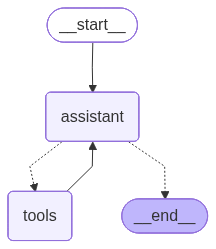

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [20]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, Can you help me find some climbing shoes based on my previous purchases?",
    "I want to do a trekking on the highest base camp in nepal, which trek would you recommend?",
]


thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "name": "John Doe",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hi there, Can you help me find some climbing shoes based on my previous purchases?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_sKseQiPmd1sGUOpzGIrG37Tk)
 Call ID: call_sKseQiPmd1sGUOpzGIrG37Tk
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

customer_interactions
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_0clnj7Kd3G7auYQzC88DfOBk)
 Call ID: call_0clnj7Kd3G7auYQzC88DfOBk
  Args:
    table_names: customer_interactions
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE customer_interactions (
	"Name" TEXT, 
	"Gender" TEXT, 
	"Age" INTEGER, 
	"Previous Purchases" TEXT, 
	"Reviews Given" TEXT
)

/*
3 rows from customer_interactions tabl